# Multiclass Diabetes Dataset Investigation

### Overview

Among the 1000 subjects, 844 are diabetic, 103 are non-diabetic, and 53 are predict-diabetic, resulting in an extreme class imbalance. We found a total of 174 duplicate subjects in the original dataset, which we subsequently removed. After removing the duplicate subjects, there were 690 diabetic, 96 non-diabetic, and 40 predict-diabetic subjects remaining.

In this project, I investaged 2 questions:
- What are the most important factors behind diabetes?
- Does gender or age have a significant impact behind diabetes?

Here are the project objectives:
- To develop a machine learning model that casn predict the stage of diabetes.
- Determine the most important factors behind the development of diabetes.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb   
from sklearn.metrics import f1_score, roc_auc_score

In [10]:
df = pd.read_csv("Multiclass Diabetes Dataset.csv") #import the dataset

In [14]:
print(df.columns)

Index(['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL',
       'VLDL', 'BMI', 'Class'],
      dtype='object')


In [12]:
print(df['Class'].value_counts()) # count of diagnosis 

Class
2    128
0     96
1     40
Name: count, dtype: int64


In [15]:
df.isna().any() # checking for NULL values

Gender    False
AGE       False
Urea      False
Cr        False
HbA1c     False
Chol      False
TG        False
HDL       False
LDL       False
VLDL      False
BMI       False
Class     False
dtype: bool

## Dataset Analysis

<Axes: xlabel='Gender', ylabel='Class'>

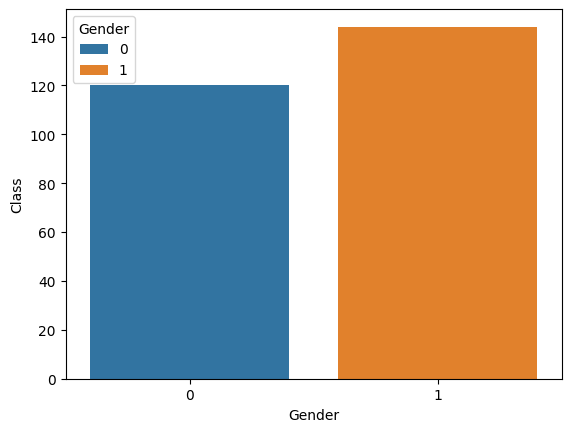

In [17]:
gender = df.groupby(['Gender']).count()['Class']
gender = gender.to_frame()
gender = gender.reset_index()
sns.barplot(gender, x = 'Gender', y = 'Class', hue = 'Gender')

<Axes: xlabel='Gender', ylabel='Class'>

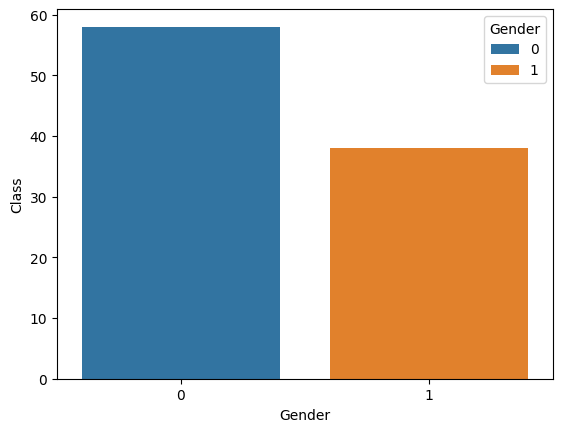

In [23]:
non_diabetic = df[df["Class"] == 0]
non_diabetic_gender = non_diabetic.groupby(['Gender']).count()['Class']
non_diabetic_gender = non_diabetic_gender.to_frame()
non_diabetic_gender = non_diabetic_gender.reset_index()
sns.barplot(non_diabetic_gender, x = "Gender", y = "Class", hue = "Gender")

<Axes: xlabel='Gender', ylabel='Class'>

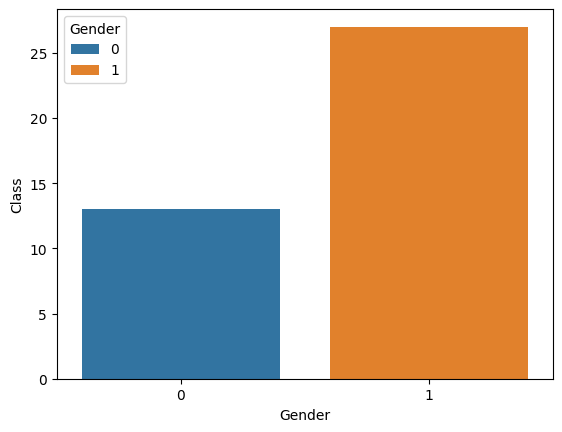

In [25]:
diabetic = df[df['Class'] == 1]
diabetic_gender = diabetic.groupby('Gender').count()['Class']
diabetic_gender = diabetic_gender.to_frame()
diabetic_gender = diabetic_gender.reset_index()
sns.barplot(diabetic_gender, x = "Gender", y = "Class", hue = "Gender")

<Axes: xlabel='Gender', ylabel='Class'>

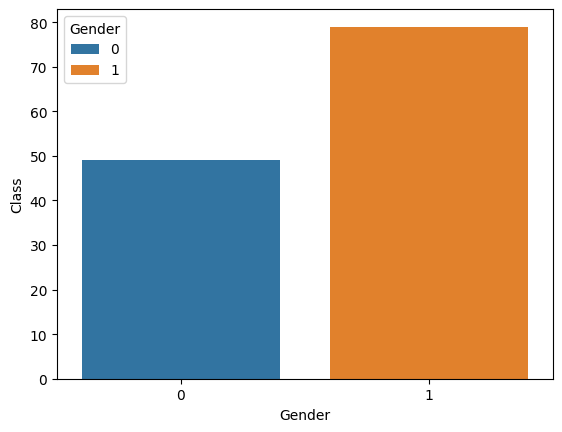

In [ ]:
pre_diabetic = df[df['Class'] == 2]
pre_diabetic_gender = pre_diabetic.groupby('Gender').count()['Class']
pre_diabetic_gender = pre_diabetic_gender.to_frame()
pre_diabetic_gender = pre_diabetic_gender.reset_index()
sns.barplot(pre_diabetic_gender, x = "Gender", y = "Class", hue = "Gender")

<Axes: xlabel='AGE'>

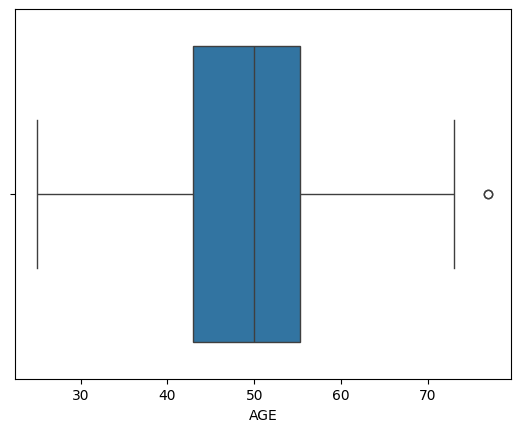

In [30]:
sns.boxplot(x=df['AGE'])

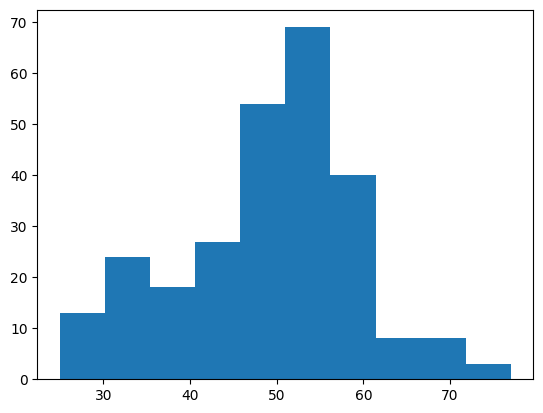

In [36]:
plt.hist(x = df['AGE'])
plt.show()

<Axes: xlabel='AGE'>

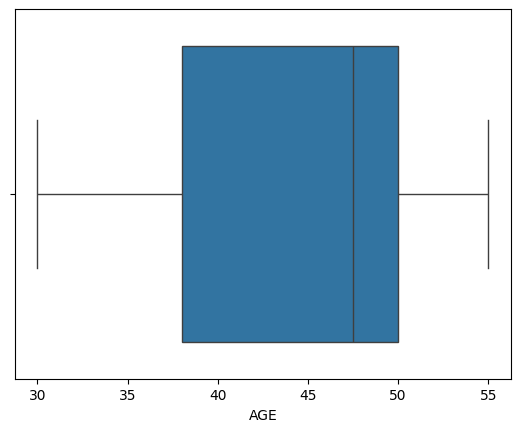

In [32]:
sns.boxplot(x=diabetic['AGE'])

(array([ 4.,  5.,  1.,  3.,  4.,  2.,  1.,  8., 10.,  2.]),
 array([30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5, 55. ]),
 <BarContainer object of 10 artists>)

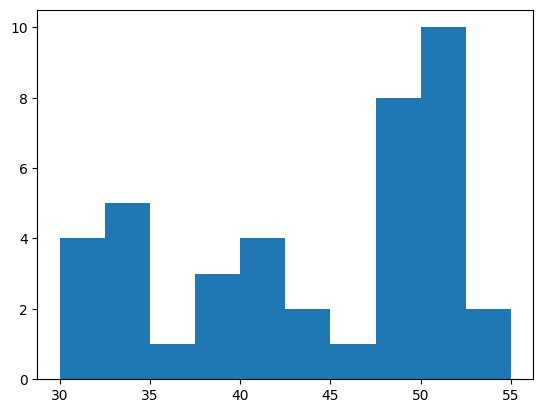

In [ ]:
plt.hist(x=diabetic['AGE'])
plt.show()

<Axes: xlabel='AGE'>

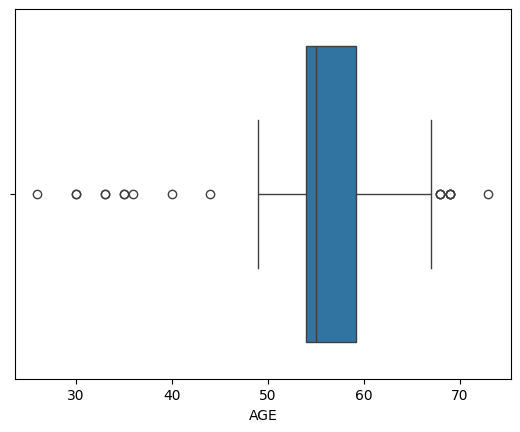

In [33]:
sns.boxplot(x=pre_diabetic['AGE'])

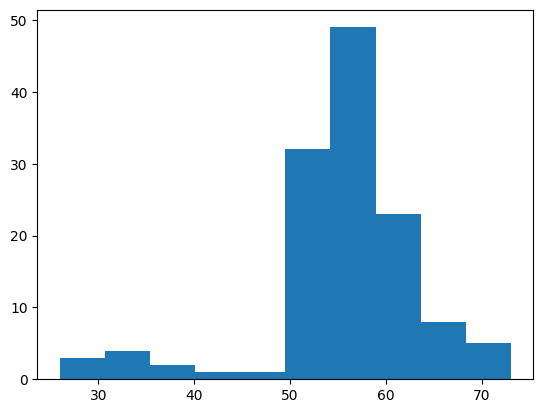

In [37]:
plt.hist(x=pre_diabetic['AGE'])
plt.show()

<Axes: xlabel='AGE'>

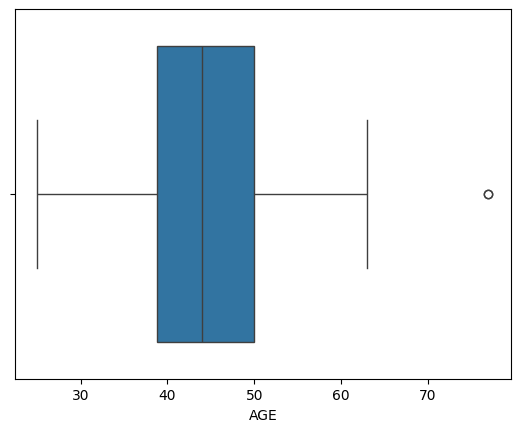

In [34]:
sns.boxplot(x=non_diabetic['AGE'])

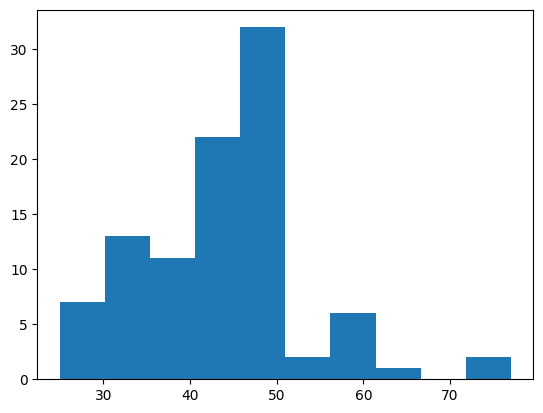

In [38]:
plt.hist(x=non_diabetic['AGE'])
plt.show()

## Hypothesis Testing

This function calculates the chi square between 2 catigorical variables.

In [42]:
def chi_square(df, index_col, column_col): 
    crosstab_result = pd.crosstab(index=df[index_col], columns=df[column_col])
    chi_square_result = stats.chi2_contingency(crosstab_result)
    p_value = chi_square_result[1]
    return p_value

### Hypothesis
Null Hypothesis (H_0): There is no difference in diabetes diagnosis among males and females

Alternative Hypothesis (H_a): There is difference in diabetes diagnosis among males and females

In [43]:
chi_square(df, 'Gender', 'Class')

np.float64(0.0008973783534576158)

The chi-square result concludes that gender is not a significant factor of developing diabetes

### To develop a machine learning model that can predict the stage of diabetes.

The first function performs a test_train_split on the given dataset. The second tests the LogisticRegression model, measuring the F1 score and ROC AUC score.

In [47]:
def train_test_sets(df): 
    df_X = df.drop(['Class'], axis=1)
    df_y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [48]:
def baseline_performance(model, X_train, X_test, y_train, y_test, average_micro=True, num_class=2): 
    baseline_model = model.fit(X_train, y_train)
    y_pred = baseline_model.predict(X_test)
    
    if average_micro: 
        baseline_f1 = f1_score(y_test, y_pred, average='micro')
    else: 
        baseline_f1 = f1_score(y_test, y_pred)
        
    y_pred_prob = baseline_model.predict_proba(X_test)
    
    if num_class > 2: 
        baseline_roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    else: 
        baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])
    
    return (baseline_model, baseline_f1, baseline_roc_auc)

#### Approach 1 - Multi-Class Classification

In [46]:
multi_class = df.copy()
multi_class

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,30.0,2
260,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,36.6,2
261,1,60,20.8,800,9.0,2.3,1.1,0.9,0.9,0.5,33.0,2
262,1,56,20.8,800,9.0,4.6,2.0,1.2,2.5,0.9,35.0,2


In [50]:
X_train, X_test, y_train, y_test = train_test_sets(multi_class)

In [52]:
lr_multi_class, lr_multi_class_f1, lr_multi_class_roc_auc = baseline_performance(LogisticRegression(random_state=42), X_train, X_test, y_train, y_test, average_micro = True, num_class=3)

print('F1 score: ' + str(lr_multi_class_f1))
print('ROC AUC score: ' + str(lr_multi_class_roc_auc))

F1 score: 0.7547169811320755
ROC AUC score: 0.865672907339574


c:\Users\micha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
lr_multi_class, lr_multi_class_f1, lr_multi_class_roc_auc = baseline_performance(lgb.LGBMClassifier(random_state=42), X_train, X_test, y_train, y_test, average_micro = True, num_class=3)

print('F1 score: ' + str(lr_multi_class_f1))
print('ROC AUC score: ' + str(lr_multi_class_roc_auc))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 11
[LightGBM] [Info] Start training from score -0.995149
[LightGBM] [Info] Start training from score -1.886122
[LightGBM] [Info] Start training from score -0.736738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

#### Approach 1 - Pre-Diabetic and Diabetic Classification

In [54]:
diabetic = df.copy()
diabetic

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,30.0,2
260,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,36.6,2
261,1,60,20.8,800,9.0,2.3,1.1,0.9,0.9,0.5,33.0,2
262,1,56,20.8,800,9.0,4.6,2.0,1.2,2.5,0.9,35.0,2


In [ ]:
diabetic.loc[diabetic['Class'] > 0, 'Class'] = 1 # grouping both diabetic and pre_diabetic
diabetic

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,30.0,1
260,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,36.6,1
261,1,60,20.8,800,9.0,2.3,1.1,0.9,0.9,0.5,33.0,1
262,1,56,20.8,800,9.0,4.6,2.0,1.2,2.5,0.9,35.0,1


In [57]:
diabetic['Class'].value_counts()

Class
1    168
0     96
Name: count, dtype: int64

In [61]:
X_train_diabetic, X_test_diabetic, y_train_diabetic, y_test_diabetic = train_test_sets(diabetic)

In [ ]:
lr_diabetic, lr_diabetic_f1, lr_diabetic_roc_auc = baseline_performance(LogisticRegression(random_state=42), X_train_diabetic, X_test_diabetic, y_train_diabetic, y_test_diabetic, average_micro = True, num_class=2)

print('F1 score: ' + str(lr_diabetic_f1))
print('ROC AUC score: ' + str(lr_diabetic_roc_auc))

F1 score: 0.8679245283018868
ROC AUC score: 0.9365079365079365


c:\Users\micha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
lr_diabetic, lr_diabetic_f1, lr_diabetic_roc_auc = baseline_performance(lgb.LGBMClassifier(random_state=42), X_train_diabetic, X_test_diabetic, y_train_diabetic, y_test_diabetic, average_micro = True, num_class=2)

print('F1 score: ' + str(lr_diabetic_f1))
print('ROC AUC score: ' + str(lr_diabetic_roc_auc))

[LightGBM] [Info] Number of positive: 133, number of negative: 78
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630332 -> initscore=0.533640
[LightGBM] [Info] Start training from score 0.533640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

#### Approach Three: Diabetic Only

In [64]:
diabetic_only = df.copy()
diabetic_only

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,30.0,2
260,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,36.6,2
261,1,60,20.8,800,9.0,2.3,1.1,0.9,0.9,0.5,33.0,2
262,1,56,20.8,800,9.0,4.6,2.0,1.2,2.5,0.9,35.0,2


In [65]:
diabetic_only.loc[diabetic_only['Class'] == 2, 'Class'] = 0 
diabetic_only

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,30.0,0
260,0,61,24.0,401,7.0,4.3,2.9,0.4,2.7,1.3,36.6,0
261,1,60,20.8,800,9.0,2.3,1.1,0.9,0.9,0.5,33.0,0
262,1,56,20.8,800,9.0,4.6,2.0,1.2,2.5,0.9,35.0,0


In [66]:
diabetic_only['Class'].value_counts()

Class
0    224
1     40
Name: count, dtype: int64

In [67]:
X_train_diabetic, X_test_diabetic, y_train_diabetic, y_test_diabetic = train_test_sets(diabetic)

In [68]:
lr_diabetic, lr_diabetic_f1, lr_diabetic_roc_auc = baseline_performance(LogisticRegression(random_state=42), X_train_diabetic, X_test_diabetic, y_train_diabetic, y_test_diabetic, average_micro = True, num_class=2)

print('F1 score: ' + str(lr_diabetic_f1))
print('ROC AUC score: ' + str(lr_diabetic_roc_auc))

F1 score: 0.8679245283018868
ROC AUC score: 0.9365079365079365


c:\Users\micha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
lr_diabetic, lr_diabetic_f1, lr_diabetic_roc_auc = baseline_performance(lgb.LGBMClassifier(random_state=42), X_train_diabetic, X_test_diabetic, y_train_diabetic, y_test_diabetic, average_micro = True, num_class=2)

print('F1 score: ' + str(lr_diabetic_f1))
print('ROC AUC score: ' + str(lr_diabetic_roc_auc))

[LightGBM] [Info] Number of positive: 133, number of negative: 78
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630332 -> initscore=0.533640
[LightGBM] [Info] Start training from score 0.533640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga